In [1]:
import numpy as np
import sympy as sp

In [2]:
k1, k2 = sp.symbols('k1 k2')

A_cl = sp.Matrix([[0,1],[1-k1,-k2]])

B = sp.Matrix([[0],[1]])

C = sp.Matrix([[1,0]])

deno = -C @ A_cl.inv() @ B


In [3]:
m1, m2, l1, l2, g = 0.5,1,8,8,10

a = m1*l1**2+m2*l1**2
b = m2*l2**2
c = m2*l1*l2
d = g*m1*l1 + g*m2*l1
e = g*m2*l2


def M(theta):
    return sp.Matrix([[a+b+2*c*sp.cos(theta[1]), b+c*sp.cos(theta[1]) ],
                      [b+c*sp.cos(theta[1]),b]])

def C(theta, dtheta):
    return sp.Matrix([[-c*sp.sin(theta[1])*dtheta[1], -c*sp.sin(theta[1])*(dtheta[0]+dtheta[1])],
                      [c*sp.sin(theta[1])*dtheta[0], 0]])

def G(theta):
    return sp.Matrix([[-d*sp.sin(theta[0])-e*sp.sin(theta[0]+theta[1])],
                      [-e*sp.sin(theta[0]+theta[1])]])


theta1, theta2, dtheta1, dtheta2, t = sp.symbols("theta_1 theta_2 dtheta_1 dtheta_2 t")
zero_one  =sp.Matrix([[0],[1]])

theta = sp.Matrix([theta1, theta2])
dtheta = sp.Matrix([dtheta1, dtheta2])

x  = sp.Matrix([theta1, theta2, dtheta1, dtheta2])
tau = sp.symbols("tau")


In [4]:
import matplotlib.pyplot as plt

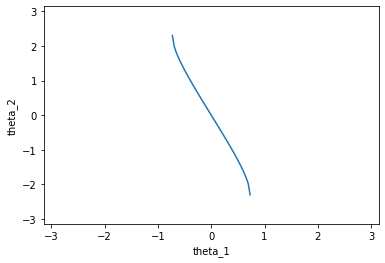

In [5]:
# p2 b

t0 = np.linspace(-e,e,50)

t1 = np.arcsin(t0/d)
t2 = np.arcsin(-t0/e) - t1

plt.xlabel("theta_1")
plt.ylabel("theta_2")

ax = plt.gca()
ax.set_xlim([-np.pi,np.pi])
ax.set_ylim([-np.pi, np.pi])

plt.plot(t1,t2)

In [6]:
# p2 c

f2 = -M(theta).inv() @ (C(theta, dtheta) @ dtheta + G(theta))

f = sp.Matrix([dtheta[0], dtheta[1], f2[0], f2[1]])

# Compute Jacobian
J = f.jacobian(x)

J.simplify()
J

g = sp.Matrix([[0],[0], M(theta).inv() @ zero_one])



In [7]:
A_linear = J.subs({theta1: 0, theta2: 0, dtheta1:0,dtheta2:0})
A_linear.eigenvals()

{-2.60995443992399: 1,
 -0.829540729271943: 1,
 0.829540729271943: 1,
 2.60995443992399: 1}

In [8]:
B_linear = g.subs({theta1: 0, theta2: 0, dtheta1:0,dtheta2:0})

g.subs({theta1: 0, theta2: 0, dtheta1:0,dtheta2:0})

Matrix([
[       0],
[       0],
[ -0.0625],
[0.140625]])

In [9]:

B = g.subs({theta1: 0, theta2: 0, dtheta1:0,dtheta2:0})


Wr = sp.Matrix.hstack(
    B, 
    A_linear * B, 
    A_linear**2 * B, 
    A_linear**3 * B
)

Wr.det()



-3.72529029846191e-7

In [10]:
def get_det(theta):
    A_l = J.subs({theta1: theta[0], theta2: theta[1], dtheta1:0,dtheta2:0})
    B_e = g.subs({theta1: theta[0], theta2: theta[1], dtheta1:0,dtheta2:0})
    Wr = sp.Matrix.hstack(
    B_e, 
    A_l *  B_e, 
    A_l**2 *  B_e, 
    A_l**3 *  B_e 
    )
    return Wr.det()

dets = []
for i in range(t2.shape[0]):
    dets.append(get_det([t1[i],t2[i]]))

Matrix([
[       0],
[       0],
[ -0.0625],
[0.140625]])

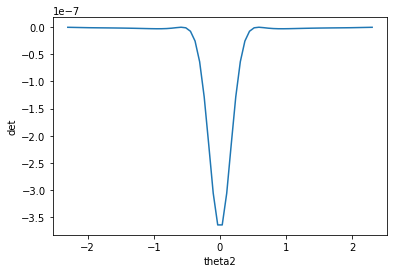

In [25]:
plt.xlabel("theta2")
plt.ylabel("det")
plt.plot(t2, dets)

B_linear

In [28]:
k1,k2,k3,k4 = sp.symbols("k_1 k_2 k_3 k_4")
K  = sp.Matrix([k1,k2,k3,k4]).T

Ap = A_linear - B_linear @ K 
s = sp.symbols('s')

# Compute the characteristic polynomial
char_poly = Ap.charpoly(s)
import control

# Desired eigenvalues (all with negative real parts)
desired_poles = [
    -0.1,
    -0.2,
    -0.4,
    -0.3,
]

A_linear = np.array(A_linear.evalf()).astype(np.float64)
B_linear = np.array(B_linear.evalf()).astype(np.float64)
# Check controllability
ctrb_matrix = control.ctrb(A_linear, B_linear)
rank = np.linalg.matrix_rank(ctrb_matrix)
if rank < A_linear.shape[0]:
    print("The system is not controllable and pole placement may not be possible.")
else:
    # Compute the gain matrix K
    K = control.place(A_linear,B_linear, desired_poles)
    print("Gain Matrix K:")
    print(K)

    # Verify the closed-loop eigenvalues
    A_p = A_linear - B_linear @ K
    closed_loop_eigenvalues = np.linalg.eigvals(A_p)
    print("\nClosed-Loop Eigenvalues:")
    print(closed_loop_eigenvalues)

AttributeError: 'numpy.ndarray' object has no attribute 'evalf'

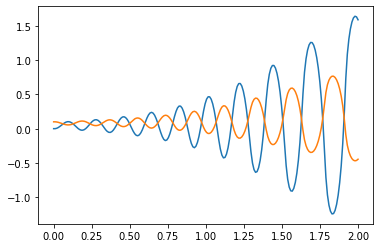

In [57]:
K  = sp.Matrix([-4000,7000, 100, 100])

tau = - K.T @ x

xdot  = f + g @ tau

time  = np.linspace(0,2,200)
delta_t = time[1] - time[0]

x_ls = [[0.1,0,0,0]]

for i in range(len(time) - 1):
    current_state = x_ls[i]
    #print(f"Time {time[i]:.2f}s: {current_state}")
    
    derivatives = xdot.subs({
        theta1: current_state[0],
        theta2: current_state[1],
        dtheta1: current_state[2],
        dtheta2: current_state[3]
    })
    
    derivatives = [float(expr) for expr in derivatives]

    #  Euler's method
    next_state = [
        current_state[j] + derivatives[j] * delta_t for j in range(len(current_state))
    ]
    
    x_ls.append(next_state)

x_ls= np.array(x_ls)

theta2_nl = x_ls[:,1]

plt.plot(time,theta2_nl)

theta1_nl = x_ls[:,0]

plt.plot(time,theta1_nl)